In [1]:
adjusted_1min_data_path = '/content/drive/MyDrive/fiver/stock prediction/dataset/historical data/ES_continuous_UNadjusted_1hour.txt'

In [2]:
import pandas as pd
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import joblib
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import matplotlib.pyplot as plt
import librosa.display
# import neptune.new as neptune
# from neptune.new.types import File
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:

df = pd.read_csv(adjusted_1min_data_path ,sep=",", header=None, names=["DateTime", "Open", "High", "Low", "Close", "Volume"])
#df['DateTime'] = pd.to_datetime(df['DateTime'])

# df['DateTime'].dt.day[2269]


In [4]:
sc = MinMaxScaler(feature_range=(0,1))
# df = sc.fit_transform(torch.from_numpy( np.array(df)[:,1:].astype(np.float) ))

df = torch.from_numpy( sc.fit_transform(np.array(df)[:,1:].astype(np.float)) )
# df = torch.from_numpy( (np.array(df)[:,2:3].astype(np.float)) )
# df =np.array(df)[:,2:3].astype(np.float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


In [38]:
df

tensor([[1.3703e-01, 1.3548e-01, 1.3737e-01, 1.3708e-01, 1.0682e-03],
        [1.3703e-01, 1.3548e-01, 1.3744e-01, 1.3708e-01, 4.6413e-04],
        [1.3709e-01, 1.3548e-01, 1.3737e-01, 1.3702e-01, 2.4612e-04],
        ...,
        [8.0485e-01, 8.0676e-01, 8.0424e-01, 8.0739e-01, 9.4078e-02],
        [8.0744e-01, 8.0682e-01, 8.0340e-01, 8.0558e-01, 1.6261e-01],
        [8.0569e-01, 8.0519e-01, 8.0503e-01, 8.0528e-01, 3.2131e-02]],
       dtype=torch.float64)

In [56]:
sequence_length = 22
batch_size = 1
input_size = df.size(dim=1)

t=int( math.floor(df.size(dim=0)/(sequence_length*batch_size))*(sequence_length*batch_size))

trainset = df[0: int(t-sequence_length*batch_size) ].view(-1,batch_size,sequence_length,input_size)#[:,:,:,1:3]  #shape [89, 64, 1024, 5]
groundtruth = df[sequence_length*batch_size: t ].view(-1,batch_size,sequence_length,input_size)[:,:,:,2:3] #shape [89, 64, 1024, 2] int(math.floor(df.size(dim=0)/(sequence_length*batch_size))*(sequence_length*batch_size))
# testset = df[math.floor(df.size(dim=0)/(sequence_length*batch_size))*(sequence_length*batch_size):]
# testset = df[:math.floor(testset.size(dim=0)/sequence_length)*sequence_length].view(-1,sequence_length,input_size) #[20, 1024, 5]
train_x =  trainset[:-10] 
train_y =  groundtruth[:-10] 
test_x =  trainset[-10:]  #train
test_y =  groundtruth[-10:] #label

number_of_batches = train_x.size(dim =0)
input_size = train_x.size(dim=3)
output_size = groundtruth.size(dim=3)
n_epochs = 100#int(input('Epochs - '))
lr=0.00001#float(input('Learning Rate - '))
hidden_dim = 1024#int(input('hidden_dim - ')) 
n_layers = 3#int(input('LSTM layers - '))


In [50]:
train_y.shape

torch.Size([4691, 1, 22, 1])

In [57]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers,batch_size):
        super(LSTMModel, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.normal = nn.BatchNorm1d(batch_size)
        #Defining the layers
        # RNN Layer
        self.lstm1 = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)#, bidirectional = False) 
        # self.lstm2 = nn.LSTM(hidden_dim,hidden_dim, n_layers, batch_first=True)  
        # Fully connected layer
        # self.fcx1 = nn.Linear(hidden_dim, hidden_dim)
        self.fcx2 = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x, hidden):
        
        # batch_size = x.size(0)
        # x = F.normalize(x)
        # x = self.normal(x)
        
        # Passing in the input and hidden state into the model and obtaining outputs
        out, h = self.lstm1(x,hidden )
        out = self.fcx2(out)
        # out = torch.sigmoid(self.fcx2(out))
        hiddenout = (h[0].to(device),h[1].to(device))
        # return torch.squeeze(out,2),hiddenout
        return out,hiddenout

def init_hidden(n_layers,batch_size, hidden_dim):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
    hidden = torch.zeros(n_layers, batch_size, hidden_dim).to(device)
    cell = torch.zeros(n_layers, batch_size, hidden_dim).to(device)
    return (hidden,cell)

In [58]:
model = LSTMModel(input_size,output_size,hidden_dim,n_layers,batch_size).to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)#, maximize = True)
hidden = init_hidden(n_layers, batch_size, hidden_dim)


In [59]:

#____________________________________________________________________________________________________________________________________________________________________________________
model.train()
for epoch in range(n_epochs): # 3 full passes over the data
  #  model.train()
    for data in range(number_of_batches):  # `data` is a batch of data
        model.zero_grad()  # sets gradients to 0 before loss calc. You will do this likely every step.
        out,h = model.forward(train_x[data].to(device).float(), hidden)
        
        # loss = loss_function(out, F.normalize(train_y[data]).to(device).float())
        loss = loss_function(out,train_y[data].to(device).float())

        # run["training/batch/loss"].log(loss)
        loss.backward( retain_graph=True)  # apply this loss backwards thru the network's parameters
        optimizer.step()  # attempt to optimize weights to account for loss/gradients
    
    print(epoch,loss)

0 tensor(0.2461, device='cuda:0', grad_fn=<MseLossBackward0>)
1 tensor(0.1350, device='cuda:0', grad_fn=<MseLossBackward0>)
2 tensor(0.1014, device='cuda:0', grad_fn=<MseLossBackward0>)
3 tensor(0.0873, device='cuda:0', grad_fn=<MseLossBackward0>)
4 tensor(0.0744, device='cuda:0', grad_fn=<MseLossBackward0>)
5 tensor(0.0584, device='cuda:0', grad_fn=<MseLossBackward0>)
6 tensor(0.0430, device='cuda:0', grad_fn=<MseLossBackward0>)
7 tensor(0.0348, device='cuda:0', grad_fn=<MseLossBackward0>)
8 tensor(0.0329, device='cuda:0', grad_fn=<MseLossBackward0>)
9 tensor(0.0328, device='cuda:0', grad_fn=<MseLossBackward0>)
10 tensor(0.0261, device='cuda:0', grad_fn=<MseLossBackward0>)
11 tensor(0.0201, device='cuda:0', grad_fn=<MseLossBackward0>)
12 tensor(0.0182, device='cuda:0', grad_fn=<MseLossBackward0>)
13 tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward0>)
14 tensor(0.0154, device='cuda:0', grad_fn=<MseLossBackward0>)
15 tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)
16

KeyboardInterrupt: ignored

In [60]:
model.eval()
out_predict =[]
test_truth = []
for k in range(len(test_y)):
  out,h = model.forward(test_x[k].to(device).float(), hidden)
  # test_truth  = np.concatenate((test_truth, np.squeeze(sc.fit_transform(test_y[k].view(-1,1).cpu().detach().numpy()) ,1)) , axis = 0)
  test_truth  = np.concatenate((test_truth, np.squeeze(test_y[k].view(-1,1).cpu().detach().numpy() ,1)) , axis = 0)
  out_predict = np.concatenate( (out_predict, torch.squeeze(out.view(-1,1),1).cpu().detach().numpy() ) , axis =0)

In [ ]:

# test_truth=torch.squeeze(F.normalize(test_y[0][0]),1).cpu().detach().numpy()
# test_truth  = torch.squeeze(F.normalize(test_y.view(-1,1)),1).cpu().detach().numpy()
test_truth  = torch.squeeze(test_y.view(-1,1),1).cpu().detach().numpy()

out_predict =torch.squeeze(out[0],1).cpu().detach().numpy()
# torch.squeeze(F.normalize(test_y[0,:]),0)[:,0].cpu().detach().numpy().shape

In [ ]:
# test_truth
out_predict



RuntimeError: ignored

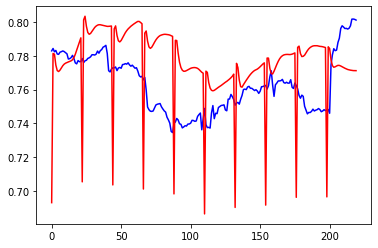

In [61]:
plt.plot(test_truth,'b')
# plt.plot(torch.squeeze(out[0,:],0)[:,0].cpu().detach().numpy(),'r')
plt.plot(out_predict,'r')
plt.show()